In [ ]:
import math
from matplotlib import projections
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

Метод Gauss-Newton

In [ ]:
def poly_reg(dim):
    return lambda w, x: sum([w[i] * x**i for i in range(dim)])


def rloss(f, x, y):
    return lambda w: np.array([(f(w, x[i]) - y[i]) for i in range(x.size)])


def diff(f, w, i, x, dx=1e-4):
    dw = np.zeros(w.size)
    dw[i] = dx
    return (f(w + dw, x) - f(w - dw, x)) / (2 * dx)


def J(f, x):
    return lambda w: np.array(
        [np.array([diff(f, w, j, x[i]) for j in range(w.size)]) for i in range(x.size)]
    )


def GN(w, x, y, reg, epoch=100, min_step=1e-5):
    r = rloss(reg, x, y)
    jac = J(reg, x)
    for i in range(epoch):
        p = -np.linalg.pinv(jac(w).T @ jac(w)) @ jac(w).T @ r(w)
        if np.linalg.norm(p) < min_step:
            return w, i
        w = w + p
    return w, epoch

Метод Powell Dog Leg

In [ ]:
def rloss_sq(f, x, y):
    return lambda w: 1 / 2 * sum([(f(w, x[i]) - y[i]) ** 2 for i in range(x.size)])


def deriv(f, w, i, h=1e-4):
    dw = np.zeros(w.size)
    dw[i] = h
    return (f(w + dw) - f(w - dw)) / (2 * h)


def J_2(f, dim: int):
    return lambda w: np.array([deriv(f, w, i) for i in range(dim)])


def sec_deriv(f, w, i, j, h=1e-4):
    dw1 = np.zeros(w.size)
    dw1[i] = h
    dw2 = np.zeros(w.size)
    dw2[j] = h
    return (
        f(w + dw1 + dw2) - f(w - dw1 + dw2) - f(w + dw1 - dw2) + f(w - dw1 - dw2)
    ) / (4 * h * h)


def H(f, dim):
    def hessian(w):
        h = np.zeros((dim, dim))
        for i in range(dim):
            for j in range(i + 1, dim):
                h[i][j] = sec_deriv(f, w, i, j)
        h = h + h.T
        for i in range(dim):
            h[i][i] = sec_deriv(f, w, i, i)
        return h

    return hessian


def PDL(
    w, x, y, reg, trust_region=1.0, max_trust_region=100.0, min_step=1e-4, epoch=300
):
    rlss = rloss_sq(reg, x, y)
    jac = J_2(rlss, w.size)
    hes = H(rlss, w.size)
    for i in range(epoch):
        g = jac(w)
        B = hes(w)
        pN = -np.linalg.pinv(B) @ g
        if np.linalg.norm(pN) <= trust_region:
            p = pN
        else:
            pGD = -((g @ g) / (g @ (B @ g))) * g
            norm_pGD = np.linalg.norm(pGD)
            if norm_pGD >= trust_region:
                p = trust_region * pGD / norm_pGD
            else:
                dp = pN - pGD
                tau = -((pGD - trust_region) @ dp) / (dp @ dp)
                p = pGD + tau * dp
            cooef = (rlss(w) - rlss(w + p)) / (-(g @ p + 0.5 * p @ (B @ p)) + (1e-8))
            norm_p = np.linalg.norm(p)
            if cooef < 0.25:
                trust_region = 0.25 * norm_p
            elif cooef > 0.75 and norm_p == trust_region:
                trust_region = min(2.0 * trust_region, max_trust_region)
            if cooef > 0.20:
                w = w + p
                if np.linalg.norm(g) < min_step:
                    return w, i
    return w, epoch

Примеры функций и работа алгоритмов выше

In [ ]:
f1 = lambda x: np.exp(x / 2) + 3 * np.sin(x) - x
regf1 = lambda w, x: np.exp(w[0] * x) + w[1] * np.sin(x) + w[2] * x
f2 = lambda x: x**2 - 3 * x + 4


def get_funct_val(f, lbound, rbound, d):
    x = np.arange(lbound, rbound)
    x = x
    y = f(x)
    y_with_noise = y + (np.random.randint(2 * d, size=rbound - lbound) - d)
    return x, y, y_with_noise


x, y, val = get_funct_val(f1, -40, 10, 3)

plt.axis((-40, 10, -50, 100))
plt.plot(x, y, "o-", label="function")
plt.plot(x, val, "o", label="input values")


regGN = regf1
ans, ep = GN(np.array([0.7, 0.7, 0.7]), x, val, regGN)
print(ans, ep)
yval = regGN(ans, x)
plt.plot(x, yval, "-", label="NG reg")

regPDL = regf1
ans, ep = PDL(np.array([0.7, 0.7, 0.7]), x, val, regPDL)
print(ans, ep)
yval = regPDL(ans, x)
plt.plot(x, yval, "-", label="PDL reg")


plt.legend()
plt.show

In [ ]:
x, y, val = get_funct_val(f2, -40, 40, 100)

plt.axis((-50, 50, -10, 1000))
plt.plot(x, y, "o-", label="function")
plt.plot(x, val, "o", label="input values")


regGN = poly_reg(3)
ans, ep = GN(np.array([1, 1, 1]), x, val, regGN)
print(ans, ep)
yval = regGN(ans, x)
plt.plot(x, yval, "-", label="NG reg")

regPDL = poly_reg(3)
ans, ep = PDL(np.array([1, 1, 1]), x, val, regPDL)
print(ans, ep)
yval = regPDL(ans, x)
plt.plot(x, yval, "-", label="PDL reg")


plt.legend()
plt.show

Метод BFGS

In [ ]:
def num_dif(f, x, i, h=1e-5):
    dx = np.zeros(x.size)
    dx[i] = dx[i] + h
    return ((f(*(x + dx)) - f(*(x - dx)))) / (2 * h)


def gradient(f, dim):
    return lambda x: np.array([num_dif(f, x, i) for i in range(dim)])


def not_wolfe(f, x, df, p, alpha, c1=1e-4, c2=0.9):
    return (f(*(x + alpha * -p)) > f(*x) - c1 * alpha * p @ p) or (
        p @ df(x + alpha * -p) > c2 * p @ p
    )


def BFGS(f, x, min_step=1e-5, epoch=300):
    data = np.zeros((epoch, x.size))
    I = np.eye(x.size)
    Hk = I
    grad_f = gradient(f, x.size)
    grad = grad_f(x)
    for i in range(epoch):
        p = -Hk @ grad
        alpha = 1
        while not_wolfe(f, x, grad_f, grad, alpha):
            alpha /= 2
            if alpha == 0:
                alpha = 1e-12
                break
        prev_x = x
        prev_grad = grad
        data[i] = x
        x = x + alpha * p
        grad = grad_f(x)
        s = x - prev_x
        y = grad - prev_grad
        if np.linalg.norm(s) < min_step:
            return data, x, i
        rho = 1.0 / (y.T @ s)
        Hk = (I - rho * np.outer(s, y)) @ Hk @ (
            I - rho * np.outer(y, s)
        ) + rho * np.outer(s, s)
    return data, x, epoch

Примеры работы BFGS

[0.99178148 0.98291826] 7.261707667821357e-05 300


<function matplotlib.pyplot.show(close=None, block=None)>

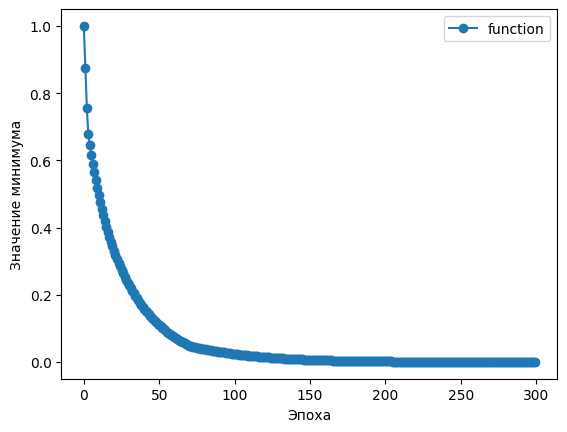

In [ ]:
f3 = lambda x, y: (1 - x) ** 2 + 10 * (y - x * x) ** 2
f4 = (
    lambda x, y, z, t: (x - y) ** 2
    + np.sin(2 * z + t) ** 2
    + t**2 * (np.exp(y + 2 * z)) ** 2
)
data, ans, ep = BFGS(f3, np.zeros(2))
x = np.arange(ep)
val = np.zeros(ep)
print(ans, f3(*ans), ep)
for i in range(ep):
    val[i] = f3(*data[i])
plt.plot(x, val, "o-", label="function")
plt.xlabel("Эпоха")
plt.ylabel("Значение минимума")
plt.legend()
plt.show


Метод LBFGS

In [ ]:
def num_dif(f, x, i, h=1e-5):
    dx = np.zeros(x.size)
    dx[i] = dx[i] + h
    return ((f(*(x + dx)) - f(*(x - dx)))) / (2 * h)


def gradient(f, dim):
    return lambda x: np.array([num_dif(f, x, i) for i in range(dim)])


def not_wolfe(f, x, df, p, alpha, c1=1e-4, c2=0.9):
    return (f(*(x + alpha * -p)) > f(*x) - c1 * alpha * p @ p) or (
        p @ df(x + alpha * -p) > c2 * p @ p
    )


class SYqueue:
    def __init__(self, queue):
        self.queue = queue

    def s(self, i):
        return self.queue[i][0]

    def y(self, i):
        return self.queue[i][1]

    def add(self, elem):
        return self.queue.append(elem)

    def pop(self):
        return self.queue.pop(0)

    def size(self):
        return len(self.queue)


def rho(s, y):
    return 1.0 / y.T @ s


def LBFGS(
    f,
    x,
    m_batch_size=30,
    epoch=300,
    min_step=1e-5,
):
    data = np.zeros((epoch, x.size))
    I = np.eye(x.size)
    grad_f = gradient(f, x.size)
    grad = grad_f(x)
    Hp = -grad
    Q = SYqueue([])
    for i in range(epoch):
        alpha = 1
        while not_wolfe(f, x, grad_f, grad, alpha):
            alpha /= 2
            if alpha == 0:
                alpha = 1e-12
                break
        data[i] = x
        prev_x = x
        prev_grad = grad
        x = x + alpha * Hp
        grad = grad_f(x)
        s = x - prev_x
        y = grad - prev_grad
        if np.linalg.norm(s) < min_step:
            return data, x, i
        if abs(y.T @ s) == 0.0:
            continue
        Q.add([s, y])
        if i >= m_batch_size:
            Q.pop()
        q = grad
        G = []
        for k in range(Q.size() - 1, -1, -1):
            g = rho(Q.s(k), Q.y(k)) * Q.s(k) @ q
            G.insert(0, g)
            q = q - g * Q.y(k)
        r = q * (s @ y) / (y @ y)
        for k in range(0, Q.size(), 1):
            betta = rho(Q.s(k), Q.y(k)) * Q.y(k) @ r
            r = r + Q.s(k) * (G[k] - betta)
        Hp = -r
    return data, x, epoch


Примеры работы LBFGS

[0.8277842  0.67949133] 0.030316166491942714 300
[0.99020038 0.9801906 ] 9.79076618030884e-05 300


<function matplotlib.pyplot.show(close=None, block=None)>

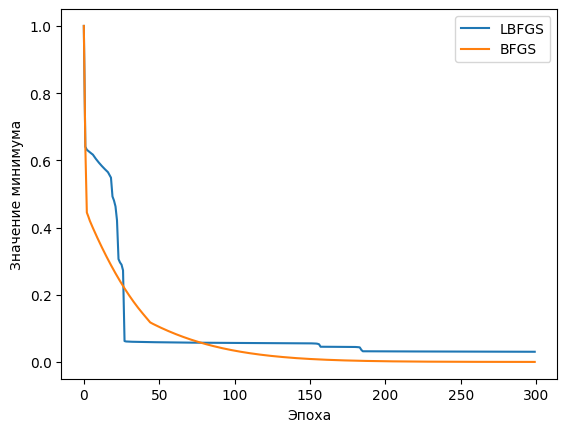

In [ ]:
f3 = lambda x, y: (1 - x) ** 2 + 20 * (y - x * x) ** 2
f4 = (
    lambda x, y, z, t: (x - y) ** 2
    + np.sin(2 * z + t) ** 2
    + t**2 * (np.exp(y + 2 * z)) ** 2
)
data, ans, ep = LBFGS(f3, np.zeros(2))
x = np.arange(ep)
val = np.zeros(ep)
print(ans, f3(*ans), ep)
for i in range(ep):
    val[i] = f3(*data[i])
plt.plot(x, val, "-", label="LBFGS")

data, ans, ep = BFGS(f3, np.zeros(2))
x = np.arange(ep)
val = np.zeros(ep)
print(ans, f3(*ans), ep)
for i in range(ep):
    val[i] = f3(*data[i])
plt.plot(x, val, "-", label="BFGS")

plt.xlabel("Эпоха")
plt.ylabel("Значение минимума")
plt.legend()
plt.show
